In [ ]:
from dotenv import load_dotenv
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize
from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.ml.feature import Word2Vec, Word2VecModel
import gensim
import nltk
import os
import sparknlp
import string
import tweepy
from pyspark.sql.types import *
from pyspark.sql import functions as F
import plotly.express as px
import plotly

nltk.download('wordnet')

In [3]:
!pip3 install tweepy

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 101 kB 3.9 MB/s eta 0:00:01


In [5]:
load_dotenv()

True

In [6]:
bearer_token = os.environ.get('bearer_token')
consumer_key = os.environ.get('consumer_key')
consumer_secret = os.environ.get('consumer_secret')
access_token = os.environ.get('access_token')
access_token_secret = os.environ.get('access_token_secret')

In [7]:
client = tweepy.Client(
    bearer_token=bearer_token,
    consumer_key=consumer_key,
    consumer_secret=consumer_secret,
    access_token=access_token,
    access_token_secret=access_token_secret,
)

In [10]:
# Get a handles Twitter ID from https://tweeterid.com/
accounts = [
    {
        'handle': 'cnnbrk',
        'id': 428333
    },
    {
        'handle': 'CNN',
        'id': 759251
    },
    {
        'handle': 'nytimes',
        'id': 807095
    },
    {
        'handle': 'BBCBreaking',
        'id': 5402612
    },
    {
        'handle': 'BBCWorld',
        'id': 742143
    },
    {
        'handle': 'TheEconomist',
        'id': 5988062
    },
    {
        'handle': 'WSJ',
        'id': 3108351
    },
    {
        'handle': 'washingtonpost',
        'id': 2467791
    },
    {
        'handle': 'TIME',
        'id': 14293310
    },
    {
        'handle': 'ABC',
        'id': 28785486
    },
    {
        'handle': 'ndtv',
        'id': 37034483
    },
    {
        'handle': 'AP',
        'id': 51241574
    },
    {
        'handle': 'XHNews',
        'id': 487118986
    },
    {
        'handle': 'HuffPost',
        'id': 14511951
    },
    {
        'handle': 'guardian',
        'id': 87818409
    },
    {
        'handle': 'BreakingNews',
        'id': 6017542
    },
    {
        'handle': 'SkyNews',
        'id': 7587032
    },
    {
        'handle': 'AJEnglish',
        'id': 4970411
    },
    {
        'handle': 'FT',
        'id': 18949452
    },
    {
        'handle': 'SkyNewsBreak',
        'id': 87416722
    },
    {
        'handle': 'politico',
        'id': 9300262
    },
    {
        'handle': 'CNBC',
        'id': 20402945
    },
    {
        'handle': 'FRANCE24',
        'id': 1994321
    },
    {
        'handle': 'guardiannews',
        'id': 788524
    },
    {
        'handle': 'Independent',
        'id': 16973333
    },
    {
        'handle': 'BBCAfrica',
        'id': 36670025
    },
    {
        'handle': 'Newsweek',
        'id': 2884771
    },
    {
        'handle': 'Telegraph',
        'id': 16343974
    },
    {
        'handle': 'RT_com',
        'id': 64643056
    },
    {
        'handle': 'CBCNews',
        'id': 6433472
    },
    {
        'handle': 'FinancialTimes',
        'id': 4898091
    },
    {
        'handle': 'Reuters',
        'id': 1652541
    },
    {
        'handle': 'SportsCenter',
        'id': 26257166
    },
    {
        'handle': 'espn',
        'id': 2557521
    }
]

In [95]:
def get_tweets(accounts, n):
    tweets = []
    for account in accounts:
        response = client.get_users_tweets(account['id'], max_results=n)
        for tweet in response.data:
            tweets.append(tweet.text)
    return tweets

In [96]:
tweets = get_tweets(accounts, 10)

In [97]:
len(tweets)

340

In [98]:
tokenized_words = []
def lemmatize_stemming(text):
    return WordNetLemmatizer().lemmatize(text, pos='v')

for tweet in tweets:
    new_tweet = tweet[:tweet.index('http')] if 'http' in tweet else tweet
    new_tweet = re.sub(r'[^a-zA-Z ]+', '', new_tweet)
    tokens = word_tokenize(new_tweet)
    remove_stopwords = [lemmatize_stemming(t.lower()) for t in tokens if not t in STOPWORDS and not t in string.punctuation and len(t) > 2]
    tokenized_words.append(",".join(remove_stopwords))

In [100]:
schema = StringType()
tokenized_words_df = spark.createDataFrame(tokenized_words, schema=schema)

In [101]:
tokenized_words_df = tokenized_words_df.withColumn("cleaned_text", F.split(F.col("value"), ","))

In [102]:
tokenized_words_df.show()

+--------------------+--------------------+
|               value|        cleaned_text|
+--------------------+--------------------+
|paul,pelosi,husba...|[paul, pelosi, hu...|
|the,fbi,issue,war...|[the, fbi, issue,...|
|bank,england,rais...|[bank, england, r...|
|pakistans,exprime...|[pakistans, expri...|
|judge,formally,se...|[judge, formally,...|
|the,feed,make,his...|[the, feed, make,...|
|trump,lawyers,saw...|[trump, lawyers, ...|
|russia,say,resume...|[russia, say, res...|
|cvs,walgreens,wal...|[cvs, walgreens, ...|
|man,accuse,attack...|[man, accuse, att...|
|turn,people,prono...|[turn, people, pr...|
|the,country,star,...|[the, country, st...|
|fight,leave,thous...|[fight, leave, th...|
|the,end,come,litt...|[the, end, come, ...|
|all,allege,member...|[all, allege, mem...|
|who,favorite,cnn,...|[who, favorite, c...|
|russian,flag,sign...|[russian, flag, s...|
|more,cheese,count...|[more, cheese, co...|
|elections,officia...|[elections, offic...|
|rumor,adele,isnt,...|[rumor, ad

In [44]:
word2vec_model = Word2VecModel.load('/common/users/shared/cs543_fall22_group3/models/word2vec')

In [103]:
result = word2vec_model.transform(tokenized_words_df.drop('value'))

In [104]:
result.show()

+--------------------+--------------------+
|        cleaned_text|      output_vectors|
+--------------------+--------------------+
|[paul, pelosi, hu...|[-0.0821658222652...|
|[the, fbi, issue,...|[-0.1995822859462...|
|[bank, england, r...|[-0.4200996284683...|
|[pakistans, expri...|[-0.0837285531684...|
|[judge, formally,...|[-0.0451845757042...|
|[the, feed, make,...|[-0.4107314121133...|
|[trump, lawyers, ...|[-0.2577153867931...|
|[russia, say, res...|[-0.4622900021763...|
|[cvs, walgreens, ...|[-0.4418119501322...|
|[man, accuse, att...|[-0.0433448063319...|
|[turn, people, pr...|[0.06139186955988...|
|[the, country, st...|[-0.0662172051767...|
|[fight, leave, th...|[-0.1190094788942...|
|[the, end, come, ...|[-0.098559905278186]|
|[all, allege, mem...|[-0.0575746349835...|
|[who, favorite, c...|[-0.0398816628148...|
|[russian, flag, s...|[-0.1780601602402...|
|[more, cheese, co...|[-0.0352580488958...|
|[elections, offic...|[-0.1379379596222...|
|[rumor, adele, is...|[0.1955163

In [47]:
model = KMeansModel.load('/common/users/shared/cs543_fall22_group3/models/k_means')

In [105]:
model.setPredictionCol("newPrediction")

KMeansModel: uid=KMeans_8db78f979b9c, k=5, distanceMeasure=euclidean, numFeatures=1

In [106]:
result = result.withColumn('features', F.col("output_vectors"))

In [107]:
transformed = model.transform(result)

In [108]:
all_transformed = transformed.toPandas()

In [109]:
all_transformed.head()

,cleaned_text,output_vectors,features,newPrediction
0,"[paul, pelosi, husband, house, speaker, nancy,...",[-0.08216582226526478],[-0.08216582226526478],2
1,"[the, fbi, issue, warn, receive, credible, inf...",[-0.19958228594623506],[-0.19958228594623506],2
2,"[bank, england, raise, rat, percentage, point,...",[-0.4200996284683545],[-0.4200996284683545],1
3,"[pakistans, exprime, minister, imran, khan, in...",[-0.08372855316847563],[-0.08372855316847563],2
4,"[judge, formally, sentence, parkland, school, ...",[-0.045184575704236826],[-0.045184575704236826],2


In [67]:
mappings = { 
0:'pop culture',
1:'finance',
2:'politics',
3:'breaking news',
4:'sports/entertainment'}

In [110]:
prediction_topics = all_transformed.apply(lambda x: mappings[x[3]], axis=1)

In [111]:
prediction_topics

0                  politics
1                  politics
2                   finance
3                  politics
4                  politics
               ...         
335                politics
336             pop culture
337    sports/entertainment
338                politics
339             pop culture
Length: 340, dtype: object

In [112]:
all_transformed['prediction_topics'] = prediction_topics

In [117]:
all_transformed = all_transformed.drop('output_vectors', axis=1)

In [118]:
all_transformed

,cleaned_text,features,newPrediction,prediction_topics
0,"[paul, pelosi, husband, house, speaker, nancy,...",[-0.08216582226526478],2,politics
1,"[the, fbi, issue, warn, receive, credible, inf...",[-0.19958228594623506],2,politics
2,"[bank, england, raise, rat, percentage, point,...",[-0.4200996284683545],1,finance
3,"[pakistans, exprime, minister, imran, khan, in...",[-0.08372855316847563],2,politics
4,"[judge, formally, sentence, parkland, school, ...",[-0.045184575704236826],2,politics
...,...,...,...,...
335,"[break, jam, harden, suffer, right, foot, tend...",[-0.03340898241315569],2,politics
336,"[espnfc, alejandro, garnacho, ronaldos, celebr...",[0.09688764677516051],0,pop culture
337,"[point, game, connor, mcdavid, leon, draisaitl...",[0.40260385908186436],4,sports/entertainment
338,"[psychologist, spur, file, lawsuit, thursday, ...",[-0.1425443911658866],2,politics


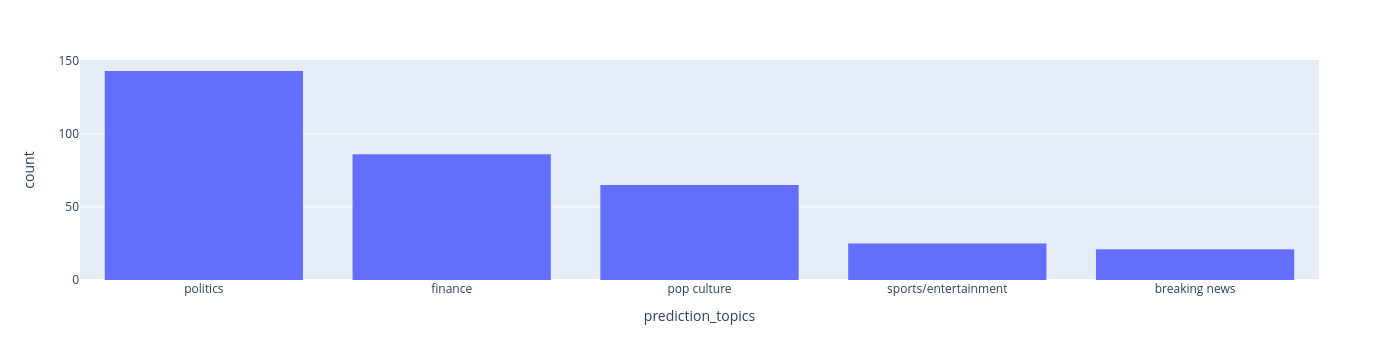

In [115]:
fig = px.histogram(all_transformed, x="prediction_topics").update_xaxes(categoryorder='total descending')
fig.show()

In [ ]:
plotly.io.write_image(bar_chart, file="./images/bar_chart_percent_fail_agent3.png", scale=5)